# Read a Graph

First we load the image and do a Hough transform that only looks for horizontal and vertical lines.

<IPython.core.display.Javascript object>


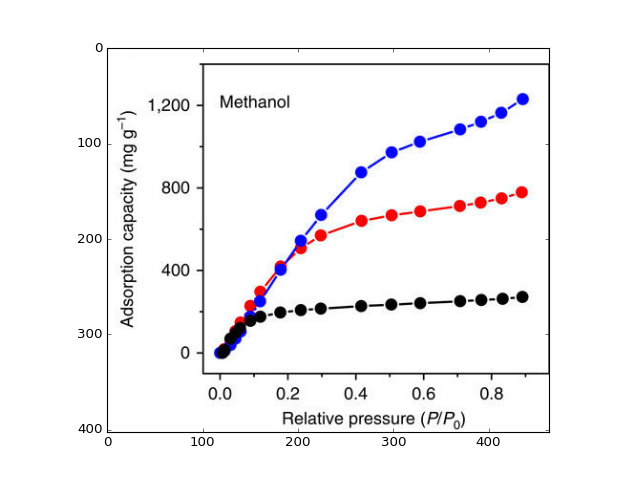

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import IPython
import scipy.ndimage as ndimage
# try:
#     import Image
# except ImportError:
from PIL import Image
import pytesseract as tes

example = 'example102.jpg'
img = cv2.imread(example)
m,n,p=img.shape

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(img,(3,3),0)
gray_blur = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
r,bw = th3 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
ret2,bw2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,bw3 = cv2.threshold(gray_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
nbw = (255-bw3)

linesP = cv2.HoughLinesP(nbw,1,np.pi/2,2, minLineLength = nbw.shape[1]/10, maxLineGap = 3)[0]

%matplotlib notebook

implot = plt.imshow(img)

## Finding axes

Now we define the axis score, [cos^2, fractional length, fractional y-coord (or x coord for y axis)]

And we find the lines with the scores closest to these to be our x and y axes


In [2]:
import find_axes
# print(linesP)
xax = find_axes.get_xaxis(linesP,nbw)
print(xax)
yax = find_axes.get_yaxis(linesP,nbw)
print(yax)


[100 341 463 341]
[100 340 100  19]


## Draw the axes

In [3]:
imlabel = img.copy();
cv2.line(imlabel,(xax[0],xax[1]),(xax[2],xax[3]),(255,0,0),2)
cv2.line(imlabel,(yax[0],yax[1]),(yax[2],yax[3]),(255,0,0),2)

<IPython.core.display.Javascript object>


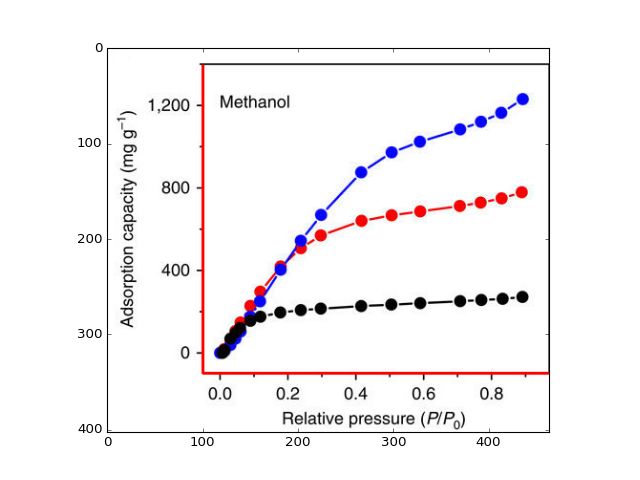

In [4]:
%matplotlib notebook

implot = plt.imshow(imlabel)
implot.set_cmap('gray')

## OCR to find Tick Labels

First we mask the image to read the text below the x-axis, removing the x-axis and its tick labels

<IPython.core.display.Javascript object>


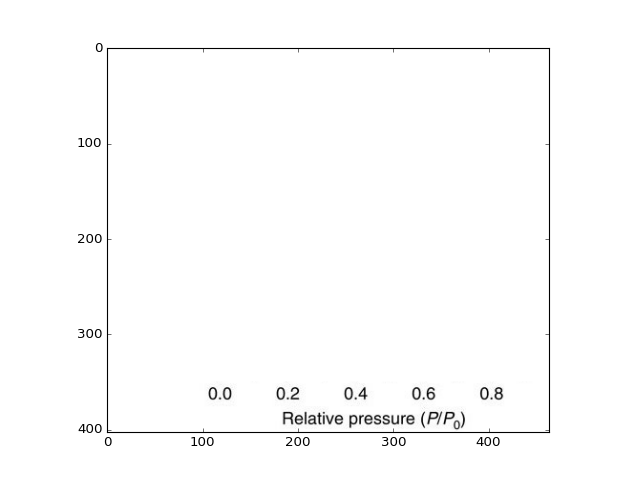

In [5]:
%matplotlib notebook

# Find where the x-ticks stop and crop the text image to be below that
below_xax_bw = np.zeros([m,n]).astype('uint8')
below_xax_bw[xax[1]:,:]=nbw[xax[1]:,:]
row_sums = below_xax_bw.sum(axis=1)
row_sums[0:xax[1]] = 1000
row_sums_list = row_sums.tolist()
text_crop_ind = row_sums_list.index(0)
text_crop_ind

xTextImg = np.ones([m,n,p]).astype('uint8')*255
xTextImg[text_crop_ind+1:,:,:]=img[text_crop_ind+1:,:,:]

cv2.imwrite('xtext.png',xTextImg)
implot = plt.imshow(xTextImg)


In [6]:
xocr = tes.image_to_string(Image.open('xtext.png'),boxes=True)

In [7]:
import ocr_tools

words = ocr_tools.clean_ocr_results(xocr)
words

[['0.0', 106, 34, 130, 47],
 ['0.2', 178, 34, 201, 47],
 ['0.4', 249, 34, 273, 47],
 ['0.6', 320, 34, 344, 47],
 ['0.8', 391, 34, 415, 47],
 ['Helakive', 185, 8, 247, 21],
 ['pressure', 254, 4, 322, 18],
 ['(P/PD)', 329, 3, 375, 22]]

In [8]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

numbers = [w for w in words if is_number(w[0])]
for w in numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
xt_labels = np.array(numbers)
xt_labels

array([[  0.00000000e+00,   1.06000000e+02,   3.69000000e+02,
          1.30000000e+02,   3.56000000e+02,   1.18000000e+02,
          3.62000000e+02],
       [  2.00000000e-01,   1.78000000e+02,   3.69000000e+02,
          2.01000000e+02,   3.56000000e+02,   1.89000000e+02,
          3.62000000e+02],
       [  4.00000000e-01,   2.49000000e+02,   3.69000000e+02,
          2.73000000e+02,   3.56000000e+02,   2.61000000e+02,
          3.62000000e+02],
       [  6.00000000e-01,   3.20000000e+02,   3.69000000e+02,
          3.44000000e+02,   3.56000000e+02,   3.32000000e+02,
          3.62000000e+02],
       [  8.00000000e-01,   3.91000000e+02,   3.69000000e+02,
          4.15000000e+02,   3.56000000e+02,   4.03000000e+02,
          3.62000000e+02]])

<IPython.core.display.Javascript object>


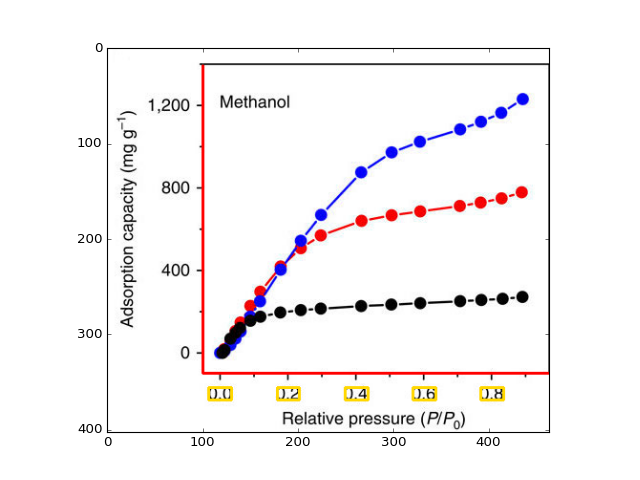

In [9]:
%matplotlib notebook

for w in numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

## Find X Ticks


## More Hough
transform on this image, looking only for vertical lines.

We then sort the results by x-coordinate and remove duplicates that are adjacent to each other by less than 5 pixels.

Finally we accept as ticks vertical lines that are separated from one another by the median spacing of all of the lines.

In [10]:
xt_dirty = find_axes.get_xticks(nbw,xax,tickMargin=11,minTickLen=0,maxGap=0)
xt_list=xt_dirty.tolist()

In [11]:
xt_match = find_axes.match_xticks(numbers,xt_list)
xt_pts = [xt_list[i] for i in xt_match]

<IPython.core.display.Javascript object>


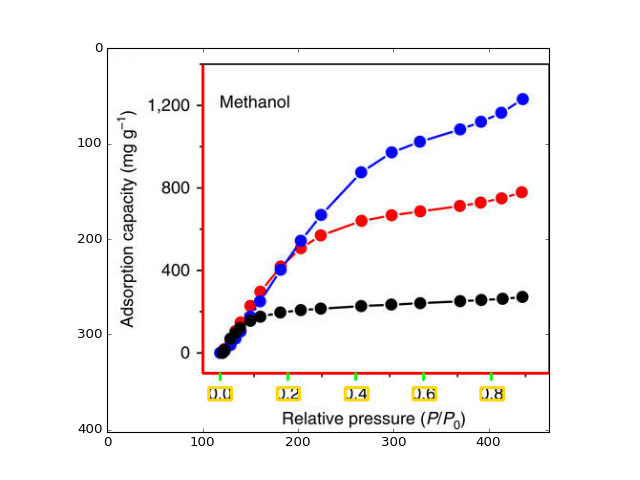

In [12]:
%matplotlib notebook
for x1,y1,x2,y2 in xt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [14]:
xt_pts_array = np.array(xt_pts)
xt_pts_array[:,0].reshape(-1,1)

array([[118],
       [189],
       [260],
       [331],
       [402]])

In [15]:
xt_labels[:,0].reshape(-1,1)

array([[ 0. ],
       [ 0.2],
       [ 0.4],
       [ 0.6],
       [ 0.8]])

## The moment you've all been waiting for...

### Regress the tick labels against the tick pixel positions to calibrate the x-axis

In [16]:
from sklearn import datasets, linear_model
regrx = linear_model.LinearRegression(fit_intercept=True)

regrx.fit(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regrx.coef_
print 'Intercept: \n', regrx.intercept_

Coefficients: 
[[ 0.0028169]]
Intercept: 
[-0.33239437]


## Now Get Y Ticks

In [17]:
# Find where the y-ticks stop and crop the text image to be left of that
left_yax_bw = np.zeros([m,n]).astype('uint8')
left_yax_bw[:yax[0],:]=nbw[:yax[0],:]
col_sums = left_yax_bw.sum(axis=0)
col_sums[yax[0]:] = 1000
col_zeros=np.where(col_sums==0)[0]
y_crop_ind=col_zeros[-1]

<IPython.core.display.Javascript object>


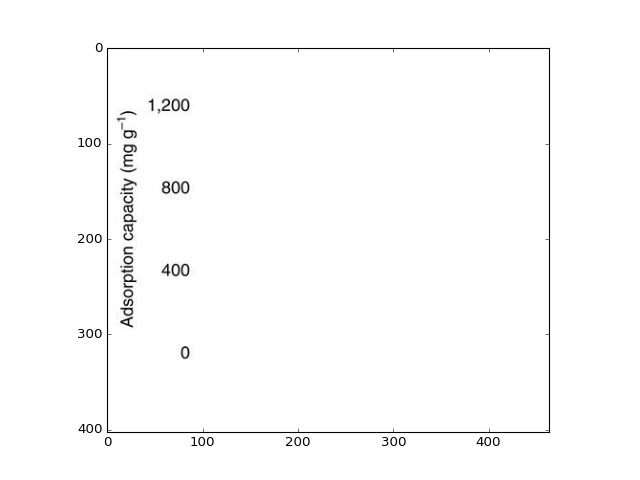

In [18]:
%matplotlib notebook
yTextImg = np.ones([m,n,p]).astype('uint8')*255
yTextImg[:,0:y_crop_ind-1,:]=img[:,0:y_crop_ind-1,:]

cv2.imwrite('ytext.png',yTextImg)
implot = plt.imshow(yTextImg)

## Unfortunately

For OCR to work effectively on the y-axis, we must remove the rotated axis title completely. This is quite challenging.

<IPython.core.display.Javascript object>


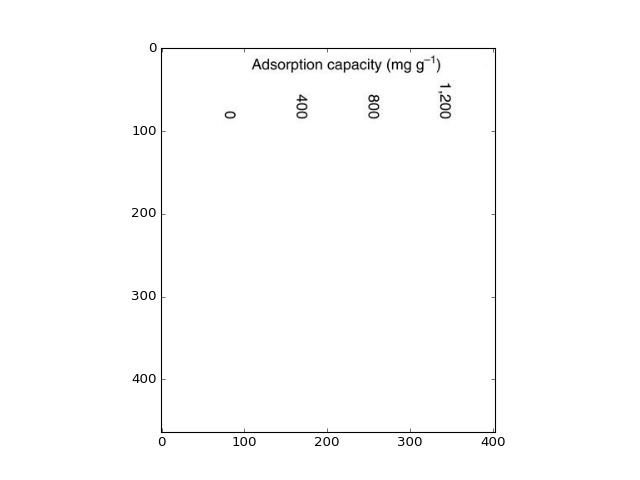

In [31]:
%matplotlib notebook

yTextRot = ndimage.interpolation.rotate(yTextImg, -90)
cv2.imwrite('ytextrot.png',yTextRot)
implot = plt.imshow(yTextRot)
implot.set_cmap('gray')

In [32]:
yRotOcr = tes.image_to_string(Image.open('ytextrot.png'),boxes=True)

### Find the longest "word" and clear its bounding box

In [33]:
yrot_words = ocr_tools.clean_ocr_results(yRotOcr,charspace=10)
word_length = [len(i[0]) for i in yrot_words]
longest_word = np.array(word_length).argmax()
lwbox = yrot_words[longest_word]
lwbox

['Adsorptiancapacity(mgg")', 109, 433, 336, 454]

In [34]:
x1 = lwbox[1]-1
y1 = lwbox[2]-1
x2 = lwbox[3]+1
y2 = lwbox[4]+1
y1 = n-y1
y2 = n-y2
yTextRot[y2:y1+1,x1:x2+1,:] = np.ones([y1-y2+1,x2-x1+1,3]).astype('uint8')*255
yText_Clean = ndimage.interpolation.rotate(yTextRot, 90)

<IPython.core.display.Javascript object>


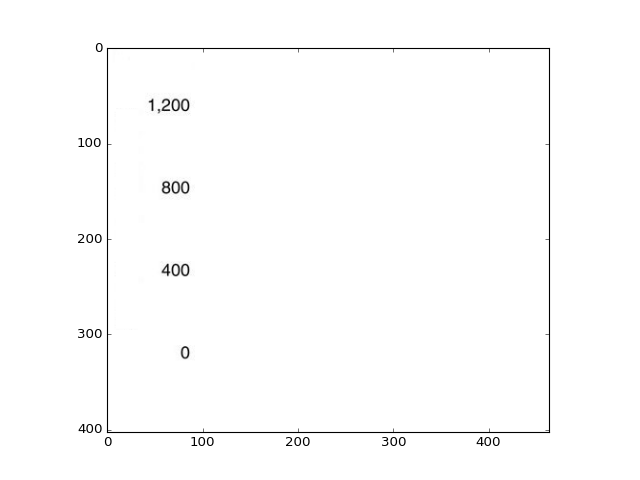

In [35]:
%matplotlib notebook
implot = plt.imshow(yText_Clean)

### Now run conventional OCR

In [36]:
cv2.imwrite('ytextclean.png',yText_Clean)
yocr = tes.image_to_string(Image.open('ytextclean.png'),boxes=True)
yl_ocr = ocr_tools.clean_ocr_results(yocr)
yl_ocr

[['1200', 44, 334, 86, 349],
 ['800', 58, 249, 86, 263],
 ['400', 57, 163, 86, 176]]

In [37]:
yt_numbers = [w for w in yl_ocr if is_number(w[0])]
for w in yt_numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
yt_label_array = np.array(yt_numbers)
yt_label_array

array([[ 1200.,    44.,    69.,    86.,    54.,    65.,    61.],
       [  800.,    58.,   154.,    86.,   140.,    72.,   147.],
       [  400.,    57.,   240.,    86.,   227.,    71.,   233.]])

<IPython.core.display.Javascript object>


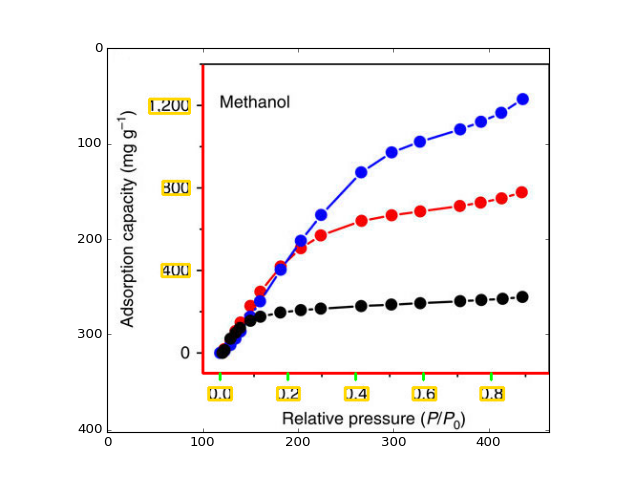

In [38]:
%matplotlib notebook

for w in yt_numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

## Now run the same label/tick matching algorithm for the y-axis

In [39]:
yt_dirty = find_axes.get_yticks(nbw,yax,tickMargin=11,minTickLen=0,maxGap=2)
yt_list=yt_dirty.tolist()

In [40]:
yt_match = find_axes.match_xticks(yt_numbers,yt_list)
yt_pts = [yt_list[i] for i in yt_match]
yt_pts

[[94, 61, 101, 61], [94, 148, 101, 148], [94, 234, 101, 234]]

<IPython.core.display.Javascript object>


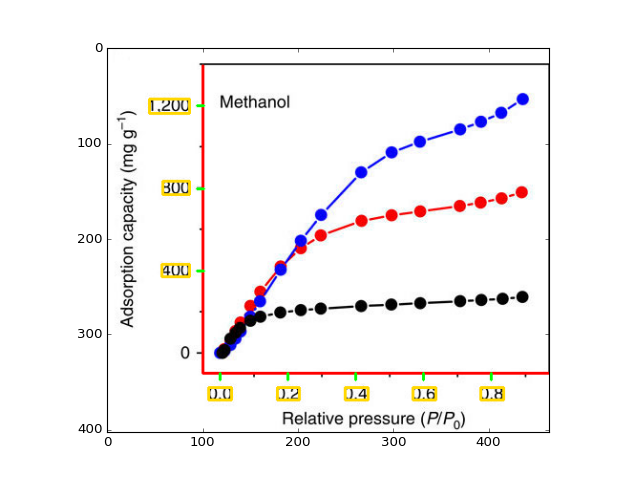

In [41]:
%matplotlib notebook
for x1,y1,x2,y2 in yt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [42]:
yt_pts_array = np.array(yt_pts)
yt_pts_array[:,1].reshape(-1,1)

array([[ 61],
       [148],
       [234]])

In [43]:
yt_label_array[:,0].reshape(-1,1)

array([[ 1200.],
       [  800.],
       [  400.]])

## Regress the y tick labels

In [44]:
from sklearn import datasets, linear_model
regry = linear_model.LinearRegression(fit_intercept=True)

regry.fit(yt_pts_array[:,1].reshape(-1,1), yt_label_array[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regry.coef_
print 'Intercept: \n', regry.intercept_

Coefficients: 
[[-4.62422595]]
Intercept: 
[ 1482.84403261]


## Finally, Extract the Data

In [45]:
from color_series_scrape import color_series_scrape

pix_pts, ROI = color_series_scrape(example, [[xax[0],xax[2]]],[[yax[3],yax[1]]], n_colors=4)


KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


<IPython.core.display.Javascript object>


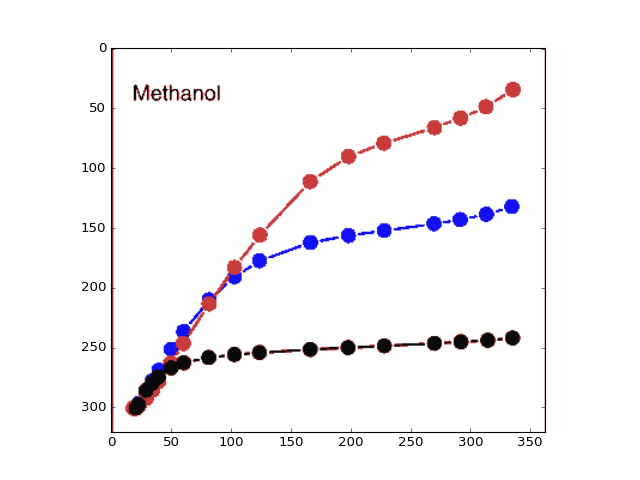

In [46]:
from cluster_data import cluster_colorspace_km, return_series

im_recon, im_label = cluster_colorspace_km(ROI[0], 4)
labels_as_ims = return_series(im_label)

%matplotlib notebook
plt.imshow(im_recon)

<IPython.core.display.Javascript object>


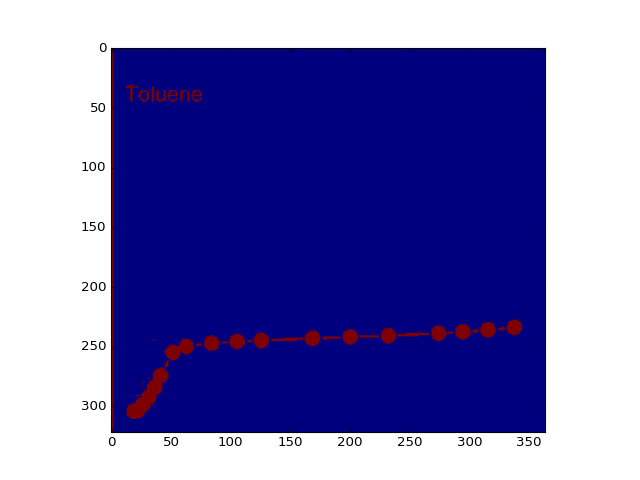

In [41]:
%matplotlib notebook

plt.imshow(labels_as_ims[0])

<IPython.core.display.Javascript object>


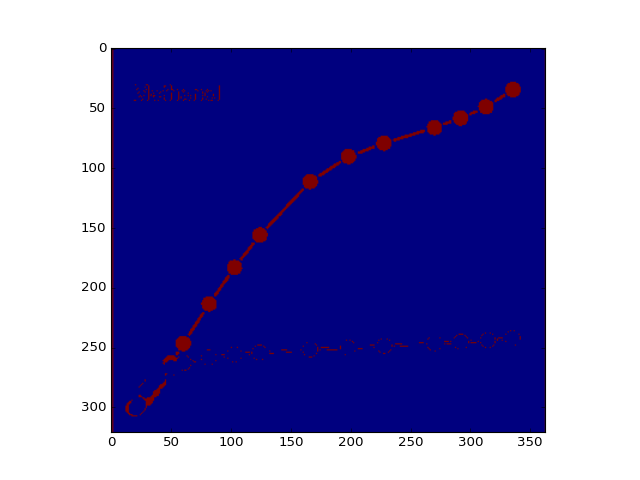

In [47]:
%matplotlib notebook

plt.imshow(labels_as_ims[1])

<IPython.core.display.Javascript object>


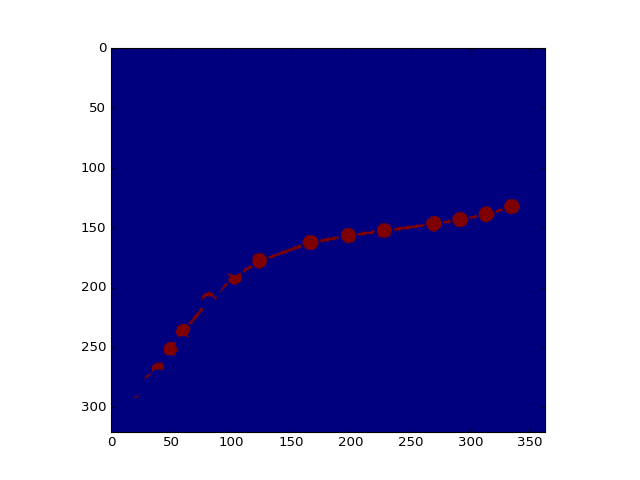

In [49]:
%matplotlib notebook

plt.imshow(labels_as_ims[2])

<IPython.core.display.Javascript object>


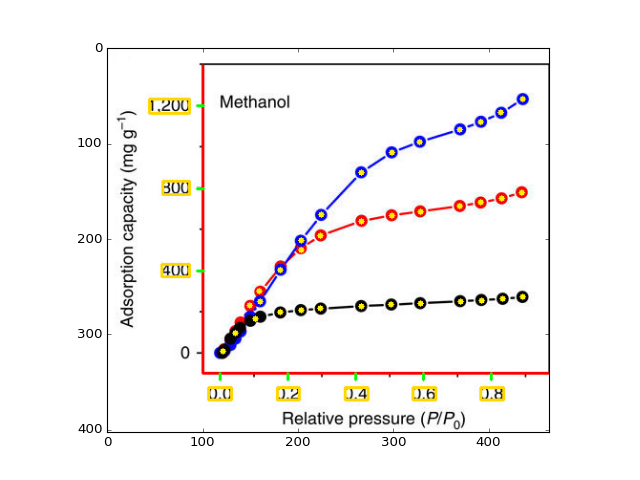

In [50]:
%matplotlib notebook
imlabel4 = imlabel.copy()
pp_list = []
for series in pix_pts[0]:
    s_list = []
    for tup in series:
        x = int(round(tup[1]))+xax[0]
        y = int(round(tup[0]))+yax[3]
        s_list.append([x,y])
    pp_list.append(s_list)

pp_list

for series in pp_list:
    for pt in series:
        cv2.circle(imlabel4,(pt[0],pt[1]), 3, (255,240,10), -1)


lastplot = plt.imshow(imlabel4)

## ... and convert the pixel values to the units of the axes

In [51]:
data_list = []
for series in pp_list:
    ser_list = []
    for pt in series:
        xdata = pt[0]*regrx.coef_+regrx.intercept_
        ydata = pt[1]*regry.coef_+regry.intercept_
        ser_list.append([xdata[0,0],ydata[0,0]])
    data_list.append(ser_list[::-1])

data_list

[[[0.0084507042253522124, 12.340179088519562],
  [0.045070422535211319, 100.20047222345966],
  [0.10422535211267614, 169.56386154051756],
  [0.17746478873239446, 201.93344322181133],
  [0.23943661971830987, 211.18189513075231],
  [0.29577464788732399, 220.43034703969329],
  [0.41690140845070423, 229.67879894863449],
  [0.50422535211267605, 238.92725085757547],
  [0.59154929577464788, 243.55147681204608],
  [0.70985915492957752, 252.79992872098705],
  [0.77183098591549293, 257.42415467545766],
  [0.83380281690140834, 266.67260658439864],
  [0.89295774647887327, 275.92105849333984]],
 [[0.11830985915492964, 252.79992872098705],
  [0.17746478873239446, 405.39938521851468],
  [0.23943661971830987, 548.75038980710099],
  [0.29859154929577469, 673.60449057780534],
  [0.41690140845070423, 877.07043257450869],
  [0.50704225352112675, 974.17917761838976],
  [0.58873239436619718, 1025.0456631175657],
  [0.70704225352112682, 1085.1606005256826],
  [0.76901408450704223, 1122.1544081614468],
  [0.8